# Import Libraries and Dataset

In [1]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import math
import time
import pandas as pd
import numpy as np
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt
import tensorflow as tf
import random as rnd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation
from keras.layers import Activation, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tqdm import tqdm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df_diabetes = pd.read_csv('/content/diabetic_data.csv')

In [4]:
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

# Exploratory Data Analysis

In [5]:
df_diabetes.replace('?', np.NaN, inplace=True)

In [6]:
columns_null_values = pd.DataFrame({'percent_missing': df_diabetes.isnull().sum() * 100 / len(df_diabetes)})
columns_null_values_greater_than_30 = columns_null_values[columns_null_values.percent_missing > 30].index
df_diabetes.drop(columns = columns_null_values_greater_than_30, axis = 1, inplace = True)

In [7]:
x = df_diabetes[['diag_3', 'readmitted']][df_diabetes[['diag_3', 'readmitted']].isna().any(axis=1)]
x['readmitted'].value_counts()

NO     994
>30    338
<30     91
Name: readmitted, dtype: int64

In [8]:
df_diabetes['race'].replace(np.NaN, 'unknown', inplace=True)
df_diabetes.dropna(axis = 0, inplace = True)

In [9]:
df_diabetes.drop(df_diabetes[df_diabetes['discharge_disposition_id'].isin([11, 19, 20, 21])].index, axis = 0, inplace = True)

In [10]:
df_diabetes.reset_index(drop = True, inplace = True)

In [11]:
df_diabetes[df_diabetes.duplicated('patient_nbr', keep = False)].sort_values(by = ['patient_nbr'])

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
4529,26264286,135,Caucasian,Female,[50-60),1,1,7,3,31,...,No,No,No,No,No,No,No,Ch,Yes,>30
4050,24437208,135,Caucasian,Female,[50-60),2,1,1,8,77,...,No,Steady,No,No,No,No,No,Ch,Yes,<30
5639,30180318,1152,AfricanAmerican,Female,[50-60),1,1,7,6,45,...,No,Down,No,No,No,No,No,Ch,Yes,>30
13529,55533660,1152,AfricanAmerican,Female,[60-70),1,1,7,10,54,...,No,Steady,No,No,No,No,No,No,Yes,>30
23613,83281464,1152,AfricanAmerican,Female,[60-70),1,1,7,12,37,...,No,Up,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96405,414418886,188634893,Caucasian,Male,[70-80),1,1,7,2,38,...,No,Steady,No,No,No,No,No,No,Yes,NO
90049,330256946,188970179,Asian,Female,[70-80),1,6,7,4,59,...,No,Steady,No,No,No,No,No,Ch,Yes,<30
98425,441488168,188970179,Asian,Female,[70-80),1,3,7,6,44,...,No,Steady,No,No,No,No,No,No,Yes,NO
87973,302575430,189257846,Asian,Male,[60-70),1,1,7,4,54,...,No,No,No,No,No,No,No,Ch,Yes,NO


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


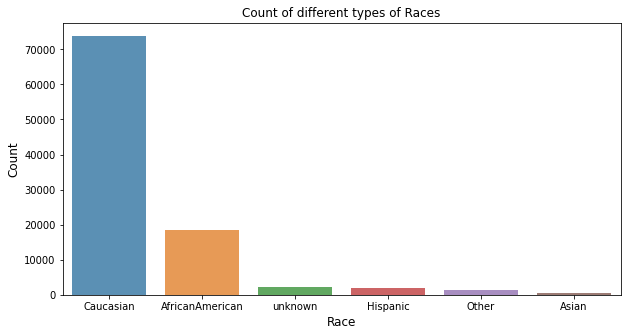

In [12]:
race_count  = df_diabetes['race'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(race_count.index, race_count.values, alpha=0.8)
plt.title('Count of different types of Races')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Race', fontsize=12)
plt.show()

In [13]:
df_diabetes.drop(columns = ['examide', 'citoglipton', 'encounter_id', 'patient_nbr', 'race'], inplace = True)

In [14]:
age_mapping_dict = {'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95}
df_diabetes.replace({'age': age_mapping_dict}, inplace = True)

readmit_mapping_dict = {'NO': 'No', '>30': 'yes', '<30': 'yes'}
df_diabetes.replace({'readmitted': readmit_mapping_dict}, inplace = True)

In [15]:
df_id_columns = df_diabetes[['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'readmitted']]
df_id_columns = df_id_columns.astype(str)

In [16]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(df_id_columns.iloc[:, :-1], df_id_columns.iloc[:, -1])
f_scores_three_values = pd.DataFrame({'columns_name': df_id_columns.columns[:-1], 'f-score': fs.scores_})
f_scores_three_values

,columns_name,f-score
0,admission_type_id,6.495572
1,discharge_disposition_id,22.022954
2,admission_source_id,548.899918


In [17]:
# removing admission type id and discharge disposition id as chi score is very less

df_diabetes.drop(columns = ['admission_type_id', 'discharge_disposition_id'], axis = 1, inplace = True)

In [18]:
df_diabetes[['admission_source_id', 'readmitted']] = df_diabetes[['admission_source_id', 'readmitted']].astype(str)

In [19]:
df_dtypes_columns = pd.DataFrame(df_diabetes.dtypes, columns = ['data_type'])

In [20]:
columns_int64 = df_dtypes_columns[df_dtypes_columns.data_type == 'int64'].index
columns_int64

Index(['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')

Text(0.5, 1.0, 'Correlation Heatmap')

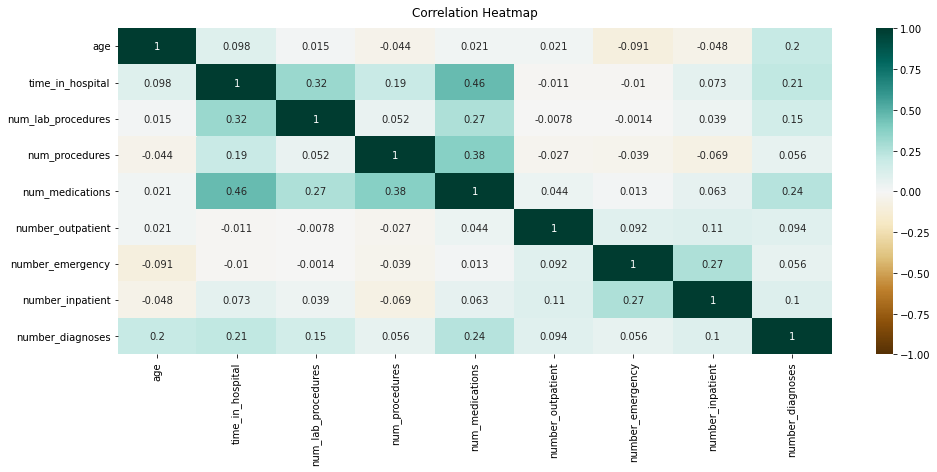

In [21]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_diabetes.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [22]:
columns_string = df_dtypes_columns[df_dtypes_columns.data_type == 'object'].index
columns_string

Index(['gender', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

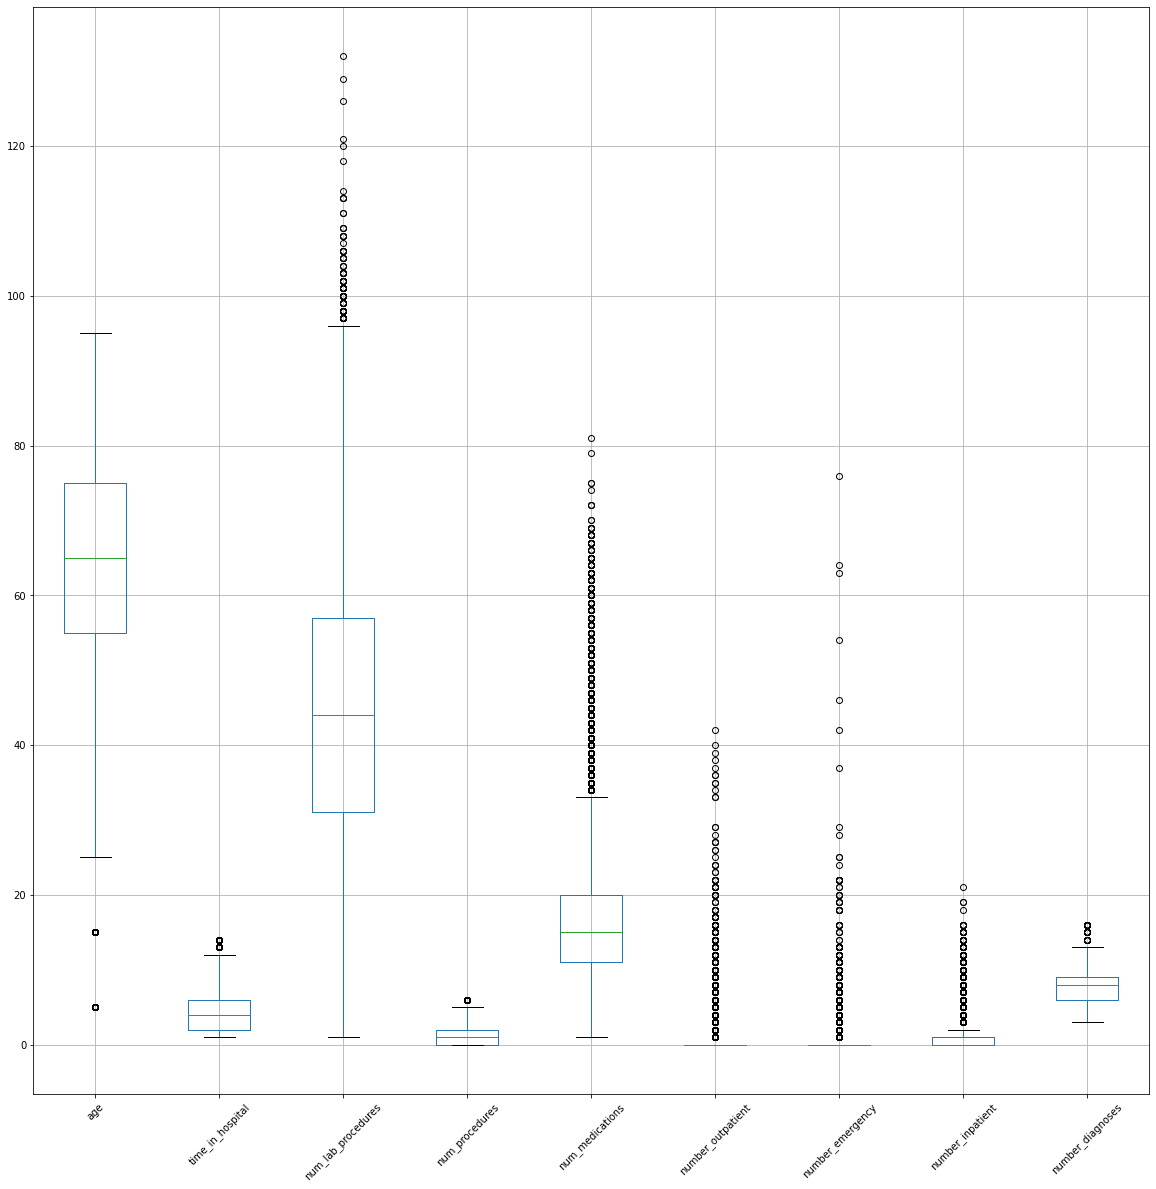

In [23]:
df_numerics = df_diabetes[columns_int64]
df_numerics.boxplot(rot = 45, figsize = (20, 20))

In [24]:
#ANOVA/F-score
# This is computed for numerical input and categorical output
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(df_numerics.iloc[:, :-1], df_diabetes.iloc[:, -1])
df_numerics_fscores = pd.DataFrame({'columns': df_numerics.columns[:-1], 'Anova Scores': fs.scores_})
df_numerics_fscores

,columns,Anova Scores
0,age,104.162908
1,time_in_hospital,265.565798
2,num_lab_procedures,207.860898
3,num_procedures,180.723028
4,num_medications,233.600679
5,number_outpatient,677.806577
6,number_emergency,1050.774113
7,number_inpatient,5073.463092


In [25]:
df_string_columns = df_diabetes[columns_string]
df_string_columns.nunique()

gender                        3
admission_source_id          17
diag_1                      714
diag_2                      742
diag_3                      787
max_glu_serum                 4
A1Cresult                     4
metformin                     4
repaglinide                   4
nateglinide                   4
chlorpropamide                4
glimepiride                   4
acetohexamide                 2
glipizide                     4
glyburide                     4
tolbutamide                   2
pioglitazone                  4
rosiglitazone                 4
acarbose                      4
miglitol                      4
troglitazone                  2
tolazamide                    3
insulin                       4
glyburide-metformin           4
glipizide-metformin           2
glimepiride-pioglitazone      2
metformin-rosiglitazone       2
metformin-pioglitazone        2
change                        2
diabetesMed                   2
readmitted                    2
dtype: i

In [26]:
hash_encoder = ce.HashingEncoder(cols = 'admission_source_id', n_components = 5)
res = hash_encoder.fit_transform(df_diabetes['admission_source_id'])
df_admission_source_id_encoded = res
df_admission_source_id_encoded.shape
df_admission_source_id_encoded.rename(columns = {'col_0': 'admission_source_id_0', 'col_1': 'admission_source_id_1', 'col_2': 'admission_source_id_2', 'col_3': 'admission_source_id_3', 'col_4': 'admission_source_id_4'}, inplace = True)

In [27]:
df_string_columns.drop(columns = ['admission_source_id'], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [28]:
df_final = pd.concat([df_numerics, df_admission_source_id_encoded], axis = 1)
df_final.head(1)

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,admission_source_id_0,admission_source_id_1,admission_source_id_2,admission_source_id_3,admission_source_id_4
0,15,3,59,0,18,0,0,0,9,1,0,0,0,0


In [29]:
df_string_columns.head(1)
le = LabelEncoder()

encoded_df = df_string_columns.iloc[:, :-1].apply(LabelEncoder().fit_transform)

encoded_df.head(1)

,gender,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,...,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,0,143,77,121,2,2,1,1,1,1,...,0,0,3,1,0,0,0,0,0,1


In [30]:
encoded_df.astype(str).dtypes

gender                      object
diag_1                      object
diag_2                      object
diag_3                      object
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide                   object
tolbutamide                 object
pioglitazone                object
rosiglitazone               object
acarbose                    object
miglitol                    object
troglitazone                object
tolazamide                  object
insulin                     object
glyburide-metformin         object
glipizide-metformin         object
glimepiride-pioglitazone    object
metformin-rosiglitazone     object
metformin-pioglitazone      object
change                      object
diabetesMed         

In [31]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(encoded_df, df_string_columns.iloc[:, -1])
df_categories_fscores = pd.DataFrame({'columns': encoded_df.columns, 'chi-Scores': fs.scores_})
df_categories_fscores

,columns,chi-Scores
0,gender,15.153822
1,diag_1,1650.705501
2,diag_2,106.430192
3,diag_3,4102.178271
4,max_glu_serum,1.252089
5,A1Cresult,0.000128
6,metformin,17.139786
7,repaglinide,0.655010
8,nateglinide,0.010572
9,chlorpropamide,0.000375


In [32]:
# since we have three different set of diagnosis values we are using the primary diag-1 value in our project and dropping the remaining two columns


df_string_columns.drop(columns = ['diag_2', 'diag_3'], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [33]:
# converting the 714 unique values in diag-1 to 9 categories based on icd codes https://www.hindawi.com/journals/bmri/2014/781670/tab2/


# create a duplicate of the diagnosis column
df_string_columns['diag1_float_value'] = df_string_columns['diag_1']
# disease codes starting with V or E are in “other” category; so recode them to 0
df_string_columns.loc[df_string_columns['diag_1'].str.contains('V'), ['diag1_float_value']] = 0
df_string_columns.loc[df_string_columns['diag_1'].str.contains('E'), ['diag1_float_value']] = 0
# also replace the unknown values with -1
df_string_columns['diag1_float_value'] = df_string_columns['diag1_float_value'].replace('?', -1)

df_string_columns['diag1_float_value'] = df_string_columns['diag1_float_value'].astype(float)
# iterate and recode disease codes between certain ranges to certain categories
for index, row in df_string_columns.iterrows():
    if (row['diag1_float_value'] >= 390 and row['diag1_float_value'] < 460) or (np.floor(row['diag1_float_value']) == 785):
        df_string_columns.loc[index, 'diag1_float_value'] = 1
    elif (row['diag1_float_value'] >= 460 and row['diag1_float_value'] < 520) or (np.floor(row['diag1_float_value']) == 786):
        df_string_columns.loc[index, 'diag1_float_value'] = 2
    elif (row['diag1_float_value'] >= 520 and row['diag1_float_value'] < 580) or (np.floor(row['diag1_float_value']) == 787):
        df_string_columns.loc[index, 'diag1_float_value'] = 3
    elif (np.floor(row['diag1_float_value']) == 250):
        df_string_columns.loc[index, 'diag1_float_value'] = 4
    elif (row['diag1_float_value'] >= 800 and row['diag1_float_value'] < 1000):
        df_string_columns.loc[index, 'diag1_float_value'] = 5
    elif (row['diag1_float_value'] >= 710 and row['diag1_float_value'] < 740):
        df_string_columns.loc[index, 'diag1_float_value'] = 6
    elif (row['diag1_float_value'] >= 580 and row['diag1_float_value'] < 630) or (np.floor(row['diag1_float_value']) == 788):
        df_string_columns.loc[index, 'diag1_float_value'] = 7
    elif (row['diag1_float_value'] >= 140 and row['diag1_float_value'] < 240):
        df_string_columns.loc[index, 'diag1_float_value'] = 8
    else:
        df_string_columns.loc[index, 'diag1_float_value'] = 0
# convert this variable to float type to enable computations later
df_string_columns['diag1_float_value'] = df_string_columns['diag1_float_value'].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [34]:
df_string_columns.drop(columns = ['diag_1'], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [35]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

x = one_hot_encoder.fit_transform(df_string_columns[df_string_columns.columns.difference(['readmitted'])]).toarray()

column_names = one_hot_encoder.get_feature_names_out()


In [36]:
df_one_hot_encoded_categories = pd.DataFrame(x, columns = column_names)
df_one_hot_encoded_categories.head(1)

,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,acarbose_Down,acarbose_No,acarbose_Steady,acarbose_Up,acetohexamide_No,acetohexamide_Steady,...,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,tolazamide_No,tolazamide_Steady,tolazamide_Up,tolbutamide_No,tolbutamide_Steady,troglitazone_No,troglitazone_Steady
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [37]:
df_final = df_final.join(df_one_hot_encoded_categories).join(df_string_columns.iloc[:, -2])
df_final.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,admission_source_id_0,...,rosiglitazone_Steady,rosiglitazone_Up,tolazamide_No,tolazamide_Steady,tolazamide_Up,tolbutamide_No,tolbutamide_Steady,troglitazone_No,troglitazone_Steady,readmitted
0,15,3,59,0,18,0,0,0,9,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,yes
1,25,2,11,5,13,2,0,1,6,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,No
2,35,2,44,1,16,0,0,0,7,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,No
3,45,1,51,0,8,0,0,0,5,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,No
4,55,3,31,6,16,0,0,0,9,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,yes


In [38]:
df_final.isnull().sum()

age                    0
time_in_hospital       0
num_lab_procedures     0
num_procedures         0
num_medications        0
                      ..
tolbutamide_No         0
tolbutamide_Steady     0
troglitazone_No        0
troglitazone_Steady    0
readmitted             0
Length: 108, dtype: int64

# Standardization

In [39]:
scaler = MinMaxScaler()
standardized_data = scaler.fit_transform(df_final.iloc[:, :-1])

In [40]:
scaler = StandardScaler()
standardized_data = scaler.fit_transform(df_final.iloc[:, :-1])

In [41]:
df_standardized = pd.concat([pd.DataFrame(standardized_data, columns = df_final.columns[:-1]), df_final.iloc[:, -1]], axis = 1)
df_standardized.head(1)

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,admission_source_id_0,...,rosiglitazone_Steady,rosiglitazone_Up,tolazamide_No,tolazamide_Steady,tolazamide_Up,tolbutamide_No,tolbutamide_Steady,troglitazone_No,troglitazone_Steady,readmitted
0,-3.280904,-0.474452,0.813712,-0.78648,0.237758,-0.293246,-0.212565,-0.50468,0.822038,0.823353,...,-0.25476,-0.041804,0.019376,-0.019112,-0.003185,0.014596,-0.014596,0.005516,-0.005516,yes


In [42]:
readmitted_mapping_dict = {'No': 0, 'yes': 1}
df_standardized.replace({'readmitted': readmitted_mapping_dict}, inplace = True)

# PCA for dimensionality reduction

In [43]:
pca = PCA()
principal_components = pca.fit_transform(df_standardized.iloc[:, :-1])
df_data_pca = principal_components[:, :60]

In [44]:
pca.explained_variance_[:60].sum()

92.0299422499934

# Train Test Split

In [45]:
X_train, X_test1, y_train, y_test1 = train_test_split(df_standardized.iloc[:, :-1], df_standardized.iloc[:, -1], stratify = df_standardized.iloc[:, -1], test_size=0.40)

In [46]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test1, y_test1, stratify = y_test1, test_size = 0.50)

In [47]:
X_train_pca, X_test1_pca, y_train_pca, y_test1_pca = train_test_split(df_data_pca, df_standardized.iloc[:, -1], stratify = df_standardized.iloc[:, -1], test_size=0.40)

In [48]:
X_test_pca, X_valid_pca, y_test_pca, y_valid_pca = train_test_split(X_test1_pca, y_test1_pca, stratify = y_test1_pca, test_size = 0.50)

In [49]:
df_time_values = pd.DataFrame(columns = ['model_name', 'train_time', 'accuracy'])

In [50]:
accuracy_scores = []

In [51]:
X_train_pca.shape

(59156, 60)

# Logistic Regression

In [52]:
class LogisticRegression1:
    def __init__(self, X_train, y_train, X_test, y_test, learning_rate, tolerance, max_iteration) -> None:
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        self.max_iteration = max_iteration

    def add_x0(self, X):
        return np.column_stack([np.ones([X.shape[0], 1]), X])

    def sigmoid(Self, z):
        sig =  1/(1 + np.exp(-z))
        return sig
    
    def cost_function(self, X, y):
        # approcah 1
        sig = self.sigmoid(X.dot(self.w))
        pred = y * np.log(sig) + (1-y) * np.log(1-sig)
        cost = - pred.sum()

        #approach 2
        pred_ = np.log(np.ones(X.shape[0]) + np.exp(X.dot(self.w))) - X.dot(self.w) * y
        cost_ = pred_.sum()
        return cost

    def gradient(self, X, y):
        sig = self.sigmoid(X.dot(self.w))
        grad = (sig - y).dot(X)
        return grad
    
    def gradient_descent(self, X, y):
        errors = []
        last_error = float('inf')

        for i in tqdm(range(self.max_iteration)):
            self.w = self.w - self.learning_rate * self.gradient(X, y)
            current_error = self.cost_function(X, y)
            diff = last_error - current_error
            last_error = current_error
            errors.append(current_error)

            if np.abs(diff) < self.tolerance:
                print("Model Stopped learning")
                break

        plt.plot(errors)
        plt.show()

        return

    def predict(self, X, threshold = 0.5):
        sig = self.sigmoid(X.dot(self.w))
        return np.where(sig <= threshold, 0, 1)
        
    def fit(self):
        print("Solving using gradient descent")

        print("\n \n")
        self.w = np.ones(self.X_train.shape[1], dtype=np.float64) * 0
        print("Shape of data : {}".format(self.X_train.shape))
        self.gradient_descent(self.X_train, self.y_train)
        y_hat_train = self.predict(self.X_train)
        accuracy, precision, recall = self.evaluate(self.y_train, y_hat_train)
        print('Accuracy is {}'.format(accuracy))
        print('Precison is {}'.format(precision))
        print('Recall is {}'.format(recall))
        print('Weight values: {}'.format(self.w))

    def evaluate(self, y, y_hat):
        y = (y == 1)
        y_hat = (y_hat == 1) 

        accuracy = (y == y_hat).sum() / y.size
        precision = (y & y_hat).sum() / y_hat.sum()
        recall = (y & y_hat).sum() / y.sum()

        return accuracy, precision, recall

## Without PCA

Commented some cells so that the process runs much faster as remaining were used for generalizing the model

In [53]:
#start_time = time.time()
#logistic_regression = LogisticRegression1(X_train, y_train, X_valid, y_valid, learning_rate=0.001, tolerance = 0.0000005, max_iteration=5000)
#print("For Training Set:")
#logistic_regression.fit()
#end_time = time.time()

#print("Validation Accuracy:")
#y_valid_pred = logistic_regression.predict(X_valid)
#print(classification_report(y_valid, y_valid_pred))

For Training Set:
Solving using gradient descent

 

Shape of data : (59156, 107)


 26%|██▋       | 1317/5000 [01:10<05:24, 11.35it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 5000/5000 [04:17<00:00, 19.41it/s]


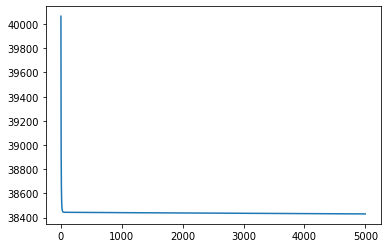

Accuracy is 0.6229461085942254
Precison is 0.6237455956469381
Recall is 0.502082286206649
Weight values: age                    0.054738
time_in_hospital       0.037354
num_lab_procedures     0.041015
num_procedures        -0.073255
num_medications        0.024865
                         ...   
tolazamide_Up          0.185997
tolbutamide_No         0.008230
tolbutamide_Steady    -0.008230
troglitazone_No       -0.332523
troglitazone_Steady    0.332523
Length: 107, dtype: float64
Validation Accuracy:
              precision    recall  f1-score   support

           0       0.62      0.73      0.67     10434
           1       0.62      0.49      0.55      9285

    accuracy                           0.62     19719
   macro avg       0.62      0.61      0.61     19719
weighted avg       0.62      0.62      0.61     19719



In [56]:
start_time = time.time()
logistic_regression1 = LogisticRegression1(X_train, y_train, X_valid, y_valid, learning_rate=0.00001, tolerance = 0.0000005, max_iteration=5000)
print("For Training Set:")
logistic_regression1.fit()
end_time = time.time()

print("Validation Accuracy:")
y_valid_pred = logistic_regression1.predict(X_valid)
print(classification_report(y_valid, y_valid_pred))

In [57]:
dict_times = {'model_name': 'logistic without pca', 'train_time': str((end_time-start_time) / 60) + ' mins'}
df_time_values = df_time_values.append(dict_times, ignore_index=True)
df_time_values

,model_name,train_time,accuracy
0,logistic without pca,4.297275014718374 mins,NaN


In [ ]:
# start_time = time.time()
# logistic_regression2 = LogisticRegression1(X_train, y_train, X_valid, y_valid, learning_rate=0.0000001, tolerance = 0.0000005, max_iteration=5000)
# print("For training set:")
# logistic_regression2.fit()
# end_time = time.time()


# print("Validation Accuracy:")
# y_valid_pred = logistic_regression2.predict(X_valid)
# print(classification_report(y_valid, y_valid_pred))

In [ ]:
# logistic_regression3 = LogisticRegression1(X_train, y_train, X_valid, y_valid, learning_rate=0.000000001, tolerance = 0.0000005, max_iteration=5000)
# print("For training set:")
# logistic_regression3.fit()

# print("Validation Accuracy:")
# y_valid_pred = logistic_regression2.predict(X_valid)
# print(classification_report(y_valid, y_valid_pred))

## With PCA

In [ ]:
# logistic_regression_pca = LogisticRegression1(X_train_pca, y_train_pca, X_valid_pca, y_valid_pca, learning_rate=0.001, tolerance = 0.0000005, max_iteration=50)
# print("For Training Set:")
# logistic_regression_pca.fit()

# print("Validation Accuracy:")
# y_valid_pred = logistic_regression_pca.predict(X_valid_pca)
# print(classification_report(y_valid_pca, y_valid_pred))

For Training Set:
Solving using gradient descent

 

Shape of data : (59156, 60)


100%|██████████| 5000/5000 [02:48<00:00, 29.61it/s]


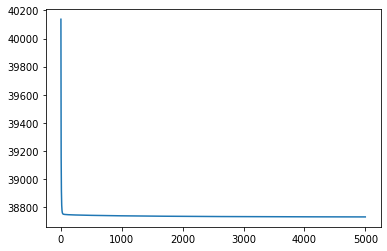

Accuracy is 0.6170802623571573
Precison is 0.6128612340536319
Recall is 0.5070725928053421
Weight values: [ 0.06242343 -0.09717476 -0.16577557  0.00197882 -0.03102038  0.00076615
 -0.03512467 -0.02416235  0.01317532  0.05992902 -0.09914535  0.13880157
 -0.12279045 -0.09320916  0.25516004  0.19431801 -0.07277016  0.00258662
 -0.06027097  0.02890361  0.02769131 -0.06369668 -0.08869457 -0.07321477
  0.18788053  0.02928126 -0.00567327  0.15650525  0.40206043  0.06607839
  0.10097939 -0.05487941 -0.09884245 -0.06037185  0.08809647 -0.01804215
  0.03802969 -0.05855786 -0.02523862 -0.00572344  0.0337844  -0.03703163
 -0.01643061 -0.02051914  0.10379509  0.0147584   0.0263863   0.09083942
  0.03363993  0.16098789  0.10421227  0.25897294 -0.19747224 -0.55982778
  0.10829415  0.16005327  0.09313395 -0.07873609  0.01504063  0.07435996]
Validation Accuracy:
              precision    recall  f1-score   support

           0       0.62      0.71      0.66     10434
           1       0.61      0.50

In [58]:
start_time = time.time()
logistic_regression1_pca = LogisticRegression1(X_train_pca, y_train_pca, X_valid_pca, y_valid_pca, learning_rate=0.00001, tolerance = 0.0000005, max_iteration=5000)
print("For Training Set:")
logistic_regression1_pca.fit()
end_time = time.time()

print("Validation Accuracy:")
y_valid_pred = logistic_regression1_pca.predict(X_valid_pca)
print(classification_report(y_valid_pca, y_valid_pred))

In [59]:
dict_times = {'model_name': 'logistic with pca', 'train_time': str((end_time-start_time) / 60) + ' mins'}
df_time_values = df_time_values.append(dict_times, ignore_index=True)
df_time_values

,model_name,train_time,accuracy
0,logistic without pca,4.297275014718374 mins,NaN
1,logistic with pca,2.8174980362256368 mins,NaN


In [60]:
# logistic_regression2_pca = LogisticRegression1(X_train_pca, y_train_pca, X_valid_pca, y_valid_pca, learning_rate=0.0000001, tolerance = 0.0000005, max_iteration=5000)
# print("For training set:")
# logistic_regression2_pca.fit()

# print("Validation Accuracy:")
# y_valid_pred = logistic_regression2_pca.predict(X_valid_pca)
# print(classification_report(y_valid_pca, y_valid_pred))

## Setting Threshold

In [61]:
threshold_values = [0.4, 0.5, 0.6]
for threshold_value in threshold_values:
    y_valid_pred = logistic_regression1_pca.predict(X_valid_pca, threshold_value)
    y_valid_pred = y_valid_pred[: len(y_valid_pred)].tolist()
    df_predicted_Values  = pd.DataFrame(y_valid_pred, columns = ['predicted value'])
    df_predicted_Values = df_predicted_Values.join(y_valid_pca.reset_index(drop = True))
    print(df_predicted_Values.value_counts())

predicted value  readmitted
1                1             7729
                 0             7128
0                0             3306
                 1             1556
dtype: int64
predicted value  readmitted
0                0             7443
                 1             4648
1                1             4637
                 0             2991
dtype: int64
predicted value  readmitted
0                0             9362
                 1             6930
1                1             2355
                 0             1072
dtype: int64


In [62]:
threshold_values = [0.4, 0.5, 0.6]
for threshold_value in threshold_values:
    y_valid_pred = logistic_regression1.predict(X_valid, threshold_value)
    y_valid_pred = y_valid_pred[: len(y_valid_pred)].tolist()
    df_predicted_Values  = pd.DataFrame(y_valid_pred, columns = ['predicted value'])
    df_predicted_Values = df_predicted_Values.join(y_valid.reset_index(drop = True))
    print(df_predicted_Values.value_counts())

predicted value  readmitted
1                1             7523
                 0             6610
0                0             3824
                 1             1762
dtype: int64
predicted value  readmitted
0                0             7624
                 1             4721
1                1             4564
                 0             2810
dtype: int64
predicted value  readmitted
0                0             9338
                 1             6733
1                1             2552
                 0             1096
dtype: int64


In [63]:
y_valid_pred = logistic_regression1_pca.predict(X_test_pca, 0.5)
print(classification_report(y_test_pca, y_valid_pred))
accuracy_scores.append(accuracy_score(y_test_pca, y_valid_pred))

              precision    recall  f1-score   support

           0       0.61      0.71      0.66     10435
           1       0.61      0.50      0.55      9284

    accuracy                           0.61     19719
   macro avg       0.61      0.61      0.60     19719
weighted avg       0.61      0.61      0.61     19719



In [64]:
y_valid_pred = logistic_regression1.predict(X_test, 0.5)
print(classification_report(y_test, y_valid_pred))
accuracy_scores.append(accuracy_score(y_test, y_valid_pred))

              precision    recall  f1-score   support

           0       0.62      0.73      0.67     10435
           1       0.62      0.49      0.55      9284

    accuracy                           0.62     19719
   macro avg       0.62      0.61      0.61     19719
weighted avg       0.62      0.62      0.61     19719



# Neural Networks with PCA

In [65]:
X_train_pca.shape

(59156, 60)

In [66]:
model_pca = Sequential()
model_pca.add(Dense(60, input_dim=60, activation='relu'))
model_pca.add(Dense(128,activation='relu'))
model_pca.add(Dense(256,activation='relu'))
model_pca.add(Dense(128,activation='relu'))
model_pca.add(Dense(2, activation='softmax'))

In [67]:
model_pca.compile(optimizer=tf.keras.optimizers.Adam(0.0000001),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [68]:
start_time = time.time()
history_pca=model_pca.fit(
    X_train_pca,y_train_pca,
    epochs=300,
    validation_split=0.15, verbose=1, batch_size=256)
end_time = time.time()

Epoch 1/300


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


197/197 [==============================] - 3s 10ms/step - loss: 0.7236 - sparse_categorical_accuracy: 0.5302 - val_loss: 0.7253 - val_sparse_categorical_accuracy: 0.5237
Epoch 2/300
197/197 [==============================] - 1s 7ms/step - loss: 0.7224 - sparse_categorical_accuracy: 0.5299 - val_loss: 0.7239 - val_sparse_categorical_accuracy: 0.5238
Epoch 3/300
197/197 [==============================] - 1s 6ms/step - loss: 0.7212 - sparse_categorical_accuracy: 0.5299 - val_loss: 0.7226 - val_sparse_categorical_accuracy: 0.5230
Epoch 4/300
197/197 [==============================] - 1s 6ms/step - loss: 0.7200 - sparse_categorical_accuracy: 0.5300 - val_loss: 0.7214 - val_sparse_categorical_accuracy: 0.5229
Epoch 5/300
197/197 [==============================] - 1s 6ms/step - loss: 0.7189 - sparse_categorical_accuracy: 0.5298 - val_loss: 0.7201 - val_sparse_categorical_accuracy: 0.5223
Epoch 6/300
197/197 [==============================] - 1s 7ms/step - loss: 0.7178 - sparse_categorical_acc

In [69]:
dict_times = {'model_name': 'NN with pca', 'train_time': str((end_time-start_time) / 60) + ' mins'}
df_time_values = df_time_values.append(dict_times, ignore_index=True)
df_time_values

,model_name,train_time,accuracy
0,logistic without pca,4.297275014718374 mins,NaN
1,logistic with pca,2.8174980362256368 mins,NaN
2,NN with pca,6.945407950878144 mins,NaN


In [70]:
y_pred = model_pca.predict(X_valid_pca)
y_pred

array([[0.6094975 , 0.39050245],
       [0.59064645, 0.4093535 ],
       [0.43110657, 0.5688934 ],
       ...,
       [0.44968677, 0.55031323],
       [0.49971288, 0.5002871 ],
       [0.5896768 , 0.41032317]], dtype=float32)

In [71]:
lst=[]

for i in range(0,len(y_pred)):
     k=np.argmax(y_pred[i]) #it gives index value of the highest probability for each iteration 
     lst.append(k)

y_pred_label=np.array(lst)

print(classification_report(y_valid_pca, y_pred_label))
accuracy_scores.append(accuracy_score(y_valid_pca, y_pred_label))

              precision    recall  f1-score   support

           0       0.57      0.74      0.65     10434
           1       0.56      0.37      0.45      9285

    accuracy                           0.57     19719
   macro avg       0.57      0.56      0.55     19719
weighted avg       0.57      0.57      0.55     19719



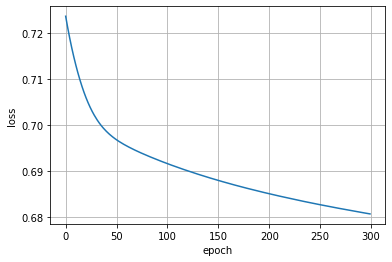

In [72]:
loss=history_pca.history['loss']
def plot(loss):
        axis=list(range(0, len(loss),1))
        fig, ax = plt.subplots()
        ax.plot(axis, loss)
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.grid()
        plt.show()
plot(loss)

# Neural Networks without PCA

In [73]:
model = Sequential()
model.add(Dense(107, input_dim=107, activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(2, activation='softmax'))

In [74]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.00001),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [75]:
start_time = time.time()
history=model.fit(
    X_train,y_train,
    epochs=100,
    validation_split=0.15, verbose=1, batch_size=256)
end_time = time.time()

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


196/197 [============================>.] - ETA: 0s - loss: 0.6911 - sparse_categorical_accuracy: 0.5384

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


197/197 [==============================] - 7s 27ms/step - loss: 0.6911 - sparse_categorical_accuracy: 0.5385 - val_loss: 0.6848 - val_sparse_categorical_accuracy: 0.5652
Epoch 2/100
197/197 [==============================] - 5s 24ms/step - loss: 0.6804 - sparse_categorical_accuracy: 0.5708 - val_loss: 0.6783 - val_sparse_categorical_accuracy: 0.5828
Epoch 3/100
197/197 [==============================] - 4s 22ms/step - loss: 0.6737 - sparse_categorical_accuracy: 0.5862 - val_loss: 0.6736 - val_sparse_categorical_accuracy: 0.5929
Epoch 4/100
197/197 [==============================] - 3s 14ms/step - loss: 0.6686 - sparse_categorical_accuracy: 0.5919 - val_loss: 0.6699 - val_sparse_categorical_accuracy: 0.5945
Epoch 5/100
197/197 [==============================] - 2s 12ms/step - loss: 0.6643 - sparse_categorical_accuracy: 0.5994 - val_loss: 0.6670 - val_sparse_categorical_accuracy: 0.5979
Epoch 6/100
197/197 [==============================] - 2s 12ms/step - loss: 0.6608 - sparse_categorica

In [76]:
dict_times = {'model_name': 'NN without pca', 'train_time': str((end_time-start_time) / 60) + ' mins'}
df_time_values = df_time_values.append(dict_times, ignore_index=True)
df_time_values

,model_name,train_time,accuracy
0,logistic without pca,4.297275014718374 mins,NaN
1,logistic with pca,2.8174980362256368 mins,NaN
2,NN with pca,6.945407950878144 mins,NaN
3,NN without pca,4.3954021692276 mins,NaN


In [77]:
y_pred = model.predict(X_valid)
y_pred

array([[0.36515644, 0.6348435 ],
       [0.5115986 , 0.48840138],
       [0.5579222 , 0.44207776],
       ...,
       [0.575114  , 0.424886  ],
       [0.3644955 , 0.63550454],
       [0.5278894 , 0.4721106 ]], dtype=float32)

In [78]:
lst=[]

for i in range(0,len(y_pred)):
     k=np.argmax(y_pred[i])
     lst.append(k)

y_pred_label=np.array(lst)

print(classification_report(y_valid, y_pred_label))
accuracy_scores.append(accuracy_score(y_valid, y_pred_label))

              precision    recall  f1-score   support

           0       0.62      0.72      0.67     10434
           1       0.61      0.50      0.55      9285

    accuracy                           0.62     19719
   macro avg       0.62      0.61      0.61     19719
weighted avg       0.62      0.62      0.61     19719



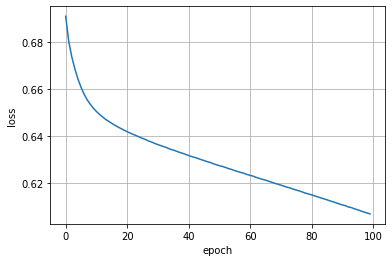

In [79]:
loss=history.history['loss']
def plot(loss):
        axis=list(range(0, len(loss),1))
        fig, ax = plt.subplots()
        ax.plot(axis, loss)
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.grid()
        plt.show()
plot(loss)

# SVM

In [80]:
df_standardized_svm = df_standardized
readmitted_mapping_dict = {0: -1, 1: 1}
df_standardized_svm.replace({'readmitted': readmitted_mapping_dict}, inplace = True)

df_standardized_svm = df_standardized_svm.groupby('readmitted', group_keys=False).apply(lambda x: x.sample(frac=0.5))

X_train_svm, X_test1_svm, y_train_svm, y_test1_svm = train_test_split(df_standardized_svm.iloc[:, :-1], df_standardized_svm.iloc[:, -1], stratify = df_standardized_svm.iloc[:, -1], test_size=0.40)

X_test_svm, X_valid_svm, y_test_svm, y_valid_svm = train_test_split(X_test1_svm, y_test1_svm, stratify = y_test1_svm, test_size = 0.50)

X_train_svm.reset_index(drop = True, inplace = True)
y_train_svm.reset_index(drop = True, inplace = True)

In [81]:
df_data_pca_svm = pd.DataFrame(df_data_pca)

df_data_pca_svm = df_data_pca_svm.join(df_standardized_svm.iloc[:, -1])
readmitted_mapping_dict = {0: -1, 1: 1}
df_standardized_svm.replace({'readmitted': readmitted_mapping_dict}, inplace = True)
df_data_pca_svm = df_data_pca_svm.groupby('readmitted', group_keys=False).apply(lambda x: x.sample(frac=0.5))

X_train_pca_svm, X_test1_pca_svm, y_train_pca_svm, y_test1_pca_svm = train_test_split(df_data_pca_svm.iloc[:, :-1], df_data_pca_svm.iloc[:, -1], stratify = df_data_pca_svm.iloc[:, -1], test_size=0.40)

X_test_pca_svm, X_valid_pca_svm, y_test_pca_svm, y_valid_pca_svm = train_test_split(X_test1_pca_svm, y_test1_pca_svm, stratify = y_test1_pca_svm, test_size = 0.50)

In [82]:
class SVM():
    def __init__(self, max_iter=100, kernel_type='linear', C=1.0, epsilon=0.001):
        self.kernels = {
            'linear' : self.kernel_linear,
            'quadratic' : self.kernel_quadratic,
            'gaussian' : self.kernel_gauss
        }
        self.max_iter = max_iter
        self.kernel_type = kernel_type
        self.C = C
        self.epsilon = epsilon
    def fit(self, X, y):
        n, d = X.shape[0], X.shape[1]
        alpha = np.zeros((n))
        kernel = self.kernels[self.kernel_type]
        count = 0
        while True:
            count += 1
            alpha_prev = np.copy(alpha)
            for j in range(0, n):
                i = self.get_rnd_int(0, n-1, j) # Get random int i~=j
                x_i, x_j, y_i, y_j = X[i,:], X[j,:], y[i], y[j]
                k_ij = kernel(x_i, x_i) + kernel(x_j, x_j) - 2 * kernel(x_i, x_j)
                if k_ij == 0:
                    continue
                alpha_prime_j, alpha_prime_i = alpha[j], alpha[i]
                (L, H) = self.compute_L_H(self.C, alpha_prime_j, alpha_prime_i, y_j, y_i)

                # Compute model parameters
                self.w = self.calc_w(alpha, y, X)
                self.b = self.calc_b(X, y, self.w)

                # Compute E_i, E_j
                E_i = self.E(x_i, y_i, self.w, self.b)
                E_j = self.E(x_j, y_j, self.w, self.b)

                # Set new alpha values
                alpha[j] = alpha_prime_j + float(y_j * (E_i - E_j))/k_ij
                alpha[j] = max(alpha[j], L)
                alpha[j] = min(alpha[j], H)

                alpha[i] = alpha_prime_i + y_i*y_j * (alpha_prime_j - alpha[j])
#                 if(j % 100 == 0):
#                     print(j)
            # Check convergence
            diff = np.linalg.norm(alpha - alpha_prev)
            if diff < self.epsilon:
                break
            #print(count)
            if count >= self.max_iter:
                print("Iteration number exceeded the max of %d iterations" % (self.max_iter))
                return
        self.b = self.calc_b(X, y, self.w)
        if self.kernel_type == 'linear':
            self.w = self.calc_w(alpha, y, X)
        # Get support vectors
        alpha_idx = np.where(alpha > 0)[0]
        support_vectors = X[alpha_idx, :]
        return support_vectors, count
    def predict(self, X):
        return self.h(X, self.w, self.b)
    def calc_b(self, X, y, w):
        b_tmp = y - np.dot(w.T, X.T)
        return np.mean(b_tmp)
    def calc_w(self, alpha, y, X):
        return np.dot(X.T, np.multiply(alpha,y))
    def h(self, X, w, b):
        return np.sign(np.dot(w.T, X.T) + b).astype(int)
    def E(self, x_k, y_k, w, b):
        return self.h(x_k, w, b) - y_k
    def compute_L_H(self, C, alpha_prime_j, alpha_prime_i, y_j, y_i):
        if(y_i != y_j):
            return (max(0, alpha_prime_j - alpha_prime_i), min(C, C - alpha_prime_i + alpha_prime_j))
        else:
            return (max(0, alpha_prime_i + alpha_prime_j - C), min(C, alpha_prime_i + alpha_prime_j))
    def get_rnd_int(self, a,b,z):
        i = z
        cnt=0
        while i == z and cnt<1000:
            i = rnd.randint(a,b)
            cnt=cnt+1
        return i
    def kernel_linear(self, x1, x2):
        return np.dot(x1, x2.T)
    def kernel_quadratic(self, x1, x2):
        return (np.dot(x1, x2.T) ** 2)
    def kernel_gauss(self,x1, x2, sigma=1):
        return np.exp(- (np.linalg.norm(x1 - x2, 2)) * 2 / (2 * sigma * 2))
    def predict_proba(self, X):
        return np.dot(self.w.T, X.T) + self.b

In [ ]:
# model = SVM(max_iter=3, kernel_type='quadratic', C=0.1, epsilon=0.000001)
# start_time = time.time()
# model.fit(X_train_svm.astype(float).to_numpy(),y_train_svm.astype(float).to_numpy())
# print("--- %s mins ---" % ((time.time() - start_time)/60.0))

In [ ]:
# Y_predicted = [model.predict(x) for x in X_valid_svm.to_numpy()]

# print(classification_report(y_valid_svm, Y_predicted))


In [ ]:
# model = SVM(max_iter=3, kernel_type='linear', C=0.1, epsilon=0.01)
# start_time = time.time()
# model.fit(X_train_svm.astype(float).to_numpy(),y_train_svm.astype(float).to_numpy())
# print("--- %s mins ---" % ((time.time() - start_time)/60.0))

In [ ]:
# Y_predicted = [model.predict(x) for x in X_valid_svm.to_numpy()]

# print(classification_report(y_valid_svm, Y_predicted))

In [ ]:
# model = SVM(max_iter=3, kernel_type='quadratic', C=0.1, epsilon=0.01)
# start_time = time.time()
# model.fit(X_train_svm.astype(float).to_numpy(),y_train_svm.astype(float).to_numpy())
# print("--- %s mins ---" % ((time.time() - start_time)/60.0))

In [ ]:
# Y_predicted = [model.predict(x) for x in X_valid_svm.to_numpy()]

# print(classification_report(y_valid_svm, Y_predicted))

In [83]:
model = SVM(max_iter=2, kernel_type='linear', C=0.1, epsilon=0.0001)
start_time = time.time()
model.fit(X_train_svm.astype(float).to_numpy(),y_train_svm.astype(float).to_numpy())
print("--- %s mins ---" % ((time.time() - start_time)/60.0))

Iteration number exceeded the max of 2 iterations
--- 2.732901843388875 mins ---


In [84]:
Y_predicted = [model.predict(x) for x in X_test_svm.to_numpy()]

print(classification_report(y_test_svm, Y_predicted))

              precision    recall  f1-score   support

          -1       0.60      0.58      0.59      5218
           1       0.54      0.56      0.55      4642

    accuracy                           0.57      9860
   macro avg       0.57      0.57      0.57      9860
weighted avg       0.57      0.57      0.57      9860



In [85]:
accuracy_scores.append(accuracy_score(y_valid_svm, Y_predicted))
dict_times = {'model_name': 'SVM without pca', 'train_time': str(((time.time() - start_time)/60.0)) + ' mins'}
df_time_values = df_time_values.append(dict_times, ignore_index=True)
df_time_values

,model_name,train_time,accuracy
0,logistic without pca,4.297275014718374 mins,NaN
1,logistic with pca,2.8174980362256368 mins,NaN
2,NN with pca,6.945407950878144 mins,NaN
3,NN without pca,4.3954021692276 mins,NaN
4,SVM without pca,2.9907443563143414 mins,NaN


In [86]:
model = SVM(max_iter=20, kernel_type='linear', C=0.01, epsilon=0.01)
start_time = time.time()
model.fit(X_train_pca_svm.astype(float).to_numpy(),y_train_pca_svm.astype(float).to_numpy())
end_time = time.time()

Iteration number exceeded the max of 20 iterations


In [87]:
Y_predicted = [model.predict(x) for x in X_valid_pca_svm.to_numpy()]

print(classification_report(y_valid_pca_svm, Y_predicted))

              precision    recall  f1-score   support

        -1.0       0.61      0.74      0.67      2609
         1.0       0.61      0.47      0.53      2321

    accuracy                           0.61      4930
   macro avg       0.61      0.60      0.60      4930
weighted avg       0.61      0.61      0.60      4930



In [88]:
Y_predicted = [model.predict(x) for x in X_test_pca_svm.to_numpy()]

print(classification_report(y_test_pca_svm, Y_predicted))

              precision    recall  f1-score   support

        -1.0       0.62      0.75      0.68      2608
         1.0       0.63      0.48      0.55      2322

    accuracy                           0.62      4930
   macro avg       0.63      0.62      0.61      4930
weighted avg       0.62      0.62      0.62      4930



In [89]:
accuracy_scores.append(accuracy_score(y_valid_pca_svm, Y_predicted))
dict_times = {'model_name': 'SVM with pca', 'train_time': str(((end_time - start_time)/60.0)) + ' mins'}
df_time_values = df_time_values.append(dict_times, ignore_index=True)
df_time_values

,model_name,train_time,accuracy
0,logistic without pca,4.297275014718374 mins,NaN
1,logistic with pca,2.8174980362256368 mins,NaN
2,NN with pca,6.945407950878144 mins,NaN
3,NN without pca,4.3954021692276 mins,NaN
4,SVM without pca,2.9907443563143414 mins,NaN
5,SVM with pca,3.3405279755592345 mins,NaN


In [90]:
df_time_values['accuracy'] = accuracy_scores

# Conclusion

From the below table we can clearly understand that logistic with PCA gave us the best model and we can choose logistic as the final model

In [91]:
df_time_values

,model_name,train_time,accuracy
0,logistic without pca,4.297275014718374 mins,0.611745
1,logistic with pca,2.8174980362256368 mins,0.617678
2,NN with pca,6.945407950878144 mins,0.568183
3,NN without pca,4.3954021692276 mins,0.616512
4,SVM without pca,2.9907443563143414 mins,0.500203
5,SVM with pca,3.3405279755592345 mins,0.519473
